# Final Project of MAPD-B: Analysis of Covid-19 papers

#### Group Members: 
Fateme Baghaei Saryazdi &nbsp; 2088827 <br>
Qiqi Zhang &nbsp; 2072838 <br>
Poornima Wickramasinghe &nbsp; 2088370

## PART 2  - Task 3: Embedding for the Title

<span style="font-size: 22px;">Introduction:</span> <br>

Word embedding is a technique in natural language processing (NLP) and machine learning that represents words as vectors in a continuous vector space. The goal of word embeddings is to capture the semantic relationships between words, so that similar words are represented by similar vectors.

Popular word embedding models include Word2Vec, GloVe (Global Vectors for Word Representation), and FastText. These models learn to map words into high-dimensional vector spaces in such a way that the spatial relationships between vectors reflect the semantic relationships between words. 

In practice, you have a vocabulary of allowed words(which is the model we used); you choose this vocabulary in advance. For each vocabulary word, a look-up table contains its embedding. This embedding can be found using the word index in the vocabulary.

To account for unknown words (the ones which are not in the vocabulary), usually a vocabulary contains a special token UNK. Alternatively, unknown tokens can be ignored or assigned a zero vector.

<img src="WordEmbedding.jpg" alt="embedding figure" width="700"/>

### Performance Benchmarking 

In [1]:
# import all the necessary libraries

# data loading 
import os
import json
import io

# time calculating in the benchmarking
import time

# for plotting
import matplotlib.pyplot as plt
import seaborn as sn

# dask packages 
from dask.distributed import Client, SSHCluster
from dask import compute
import dask.array as da
import dask.dataframe as dd
import dask.bag as db

# cleaning the text
from nltk import word_tokenize
from nltk.corpus import stopwords

# to calculate cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
import numpy as np


In [2]:
# Load the covid paper dataset

def load_data_files(json_file):
    
    with open(os.path.join(folder_path, json_file), 'r') as file:
        data = json.load(file)
        
    return data

folder_path = '/home/wickramasinghemudiyanselage/comm_use_subset/comm_use_subset'
json_list = os.listdir(folder_path)

In [3]:
# pick up 1000 papers form the dataset load before
json_list=json_list[:1000]

In [4]:
print('The total number of the covid paper to be analyzed in task 3 is:', len(json_list))

The total number of the covid paper to be analyzed in task 3 is: 1000


In [5]:
# Load the pre-trained model for title embedding vector assign

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    
    # To pick 10000 words from the model
    line_count = 0  
    for line in fin:
        if line_count >= 10000: 
            break  
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
        line_count += 1
        
    # close the file after reading
    fin.close()  
    
    return data

model = load_vectors('wiki.en.vec')

In [6]:
print('For an example, the vector for word hello is:\n')
print(model.get('hello'))
print()
print('The length of a vector is:', len(model.get('hello')))

For an example, the vector for word hello is:

[-0.15945, -0.18259, 0.033443, 0.18813, -0.067903, -0.13663, -0.25559, 0.11, 0.17275, 0.051971, -0.023302, 0.038866, -0.24515, -0.21588, 0.35925, -0.082526, 0.12176, -0.26775, 0.10072, -0.13639, -0.092658, 0.51837, 0.17736, 0.094878, -0.18461, -0.042829, 0.014114, 0.16811, -0.18565, 0.034976, -0.10293, 0.17954, -0.052766, 0.072047, -0.42704, -0.11616, -0.0094875, 0.14199, -0.22782, -0.017292, 0.082802, -0.44512, -0.075935, -0.14392, -0.082461, 0.20123, -0.095344, -0.11042, -0.46817, 0.20362, -0.1714, -0.4985, 0.28963, -0.10305, 0.20393, 0.52971, -0.25396, -0.51891, 0.29941, 0.17933, 0.30683, 0.25828, -0.18168, -0.10225, -0.11435, -0.16304, -0.12424, 0.32814, -0.23099, 0.17912, 0.099206, 0.18595, 0.27996, 0.18323, -0.17397, 0.26633, -0.018151, 0.28386, 0.17328, 0.29131, 0.082289, 0.1856, -0.15544, 0.23311, 0.36578, -0.30802, -0.15908, 0.40382, 0.15332, -0.1163, 0.13978, 0.064237, 0.22087, 0.082723, 0.12785, -0.066854, -0.023016, -0.19224, -

In [7]:
# Extract paper-id and calculate the title embedding
def titles_result(line):
    
    # extract paper-id and title part from the data
    paper_id = line['paper_id']
    title = line['metadata']['title']
    
    # clean the title: tokenize and remove the stopwords
    title_tokens = word_tokenize(line['metadata']['title'])
    title_tokens_clean = clean_tokens(title_tokens)
    
    # calculate the embedding matrix for cleaned titles
    matrix = embedding_matrix(title_tokens_clean)
    
    # return a bag composed by 'paper-id' and 'title-embedding'
    return{'paper-id': paper_id,
           'title': title,
           #'title-tokens': title_tokens_clean,
          'title-embedding': matrix}

# Remove punctuation, numbers and stopwords
def clean_tokens(unclean_tokens):
    
    # Remove punctuation and numbers
    alphabetic_tokens = [word for word in unclean_tokens if word.isalpha()]

    # Remove stop-words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word.lower() for word in alphabetic_tokens if word.lower() not in stop_words]
    
    return filtered_tokens
    

# Calculate the embedding matrix for a line
def embedding_matrix(cleaned_tokens):
    
    vector = [model.get(word) for word in cleaned_tokens if model.get(word)]
    matrix = [x for x in vector]
    
    return matrix

In [8]:
# number of partitions 
# npartitions = [1, 2, 4, 8, 16, 32, 64, 128]
npartitions = [1, 2, 4, 8, 16]

# Calculate the time spend for different values of partition
def calculate_time_t3(npartitions):
    
    start_time = time.perf_counter()
    
    # Load the paper with different values of npartitions as bag 
    bag_t3 = db.from_sequence(json_list, npartitions = npartitions).map(load_data_files)
    
    # calculate the title embedding and return the list result
    titles_t3 = bag_t3.map(titles_result).compute(npartitions = npartitions)
    
    end_time = time.perf_counter()
    time_taken = end_time - start_time
    
    return time_taken

In [9]:
# number of workers
# nworkers = [1, 2, 4, 8, 16, 32, 64, 128]
nworkers = [1, 2, 4, 8, 16]

# claim 3 vms name
scheduler = '10.67.22.110'
worker1 = '10.67.22.156'
worker2 = '10.67.22.62'

In [10]:
# run the loop for benchmarking
bm_result_t3 = np.full((len(npartitions) , len(nworkers)) , np.nan)

for i , nws in enumerate(nworkers):

    cluster = SSHCluster([scheduler, worker1, worker2],
                    scheduler_options={"port": 0, "dashboard_address": ":8888"},
                    connect_options={"known_hosts": None}, 
                    worker_options={"n_workers": nws})

    client = Client(cluster)

    for j , nps in enumerate(npartitions):
        bm_result = calculate_time_t3(nps)
        bm_result_t3[j][i] = bm_result 
        print('For number of partitions is:', nps, 'and number of workers is:', nws * 2 , 'the running time is:', bm_result, 'seconds')

    client.close()
    cluster.close()

2024-01-28 22:05:52,092 - distributed.deploy.ssh - INFO - 2024-01-28 22:05:52,091 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-01-28 22:05:52,094 - distributed.deploy.ssh - INFO - /home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8888 is already in use.
2024-01-28 22:05:52,095 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2024-01-28 22:05:52,096 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 36647 instead
2024-01-28 22:05:52,097 - distributed.deploy.ssh - INFO - warnings.warn(
2024-01-28 22:05:52,118 - distributed.deploy.ssh - INFO - 2024-01-28 22:05:52,118 - distributed.scheduler - INFO - State start
2024-01-28 22:05:52,121 - distributed.deploy.ssh - INFO - 2024-01-28 22:05:52,120 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22

For number of partitions is: 1 and number of workers is: 2 the running time is: 2.707646083086729 seconds
For number of partitions is: 2 and number of workers is: 2 the running time is: 1.5824323678389192 seconds
For number of partitions is: 4 and number of workers is: 2 the running time is: 2.2594258366152644 seconds
For number of partitions is: 8 and number of workers is: 2 the running time is: 3.3903319304808974 seconds
For number of partitions is: 16 and number of workers is: 2 the running time is: 4.818593146279454 seconds


2024-01-28 22:06:09,577 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:09,576 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-01-28 22:06:09,578 - distributed.deploy.ssh - INFO - /home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8888 is already in use.
2024-01-28 22:06:09,579 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2024-01-28 22:06:09,579 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 40505 instead
2024-01-28 22:06:09,579 - distributed.deploy.ssh - INFO - warnings.warn(
2024-01-28 22:06:09,603 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:09,602 - distributed.scheduler - INFO - State start
2024-01-28 22:06:09,605 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:09,605 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22

For number of partitions is: 1 and number of workers is: 4 the running time is: 2.5183159969747066 seconds
For number of partitions is: 2 and number of workers is: 4 the running time is: 1.5993404360488057 seconds
For number of partitions is: 4 and number of workers is: 4 the running time is: 1.6206237440928817 seconds
For number of partitions is: 8 and number of workers is: 4 the running time is: 2.0742057729512453 seconds
For number of partitions is: 16 and number of workers is: 4 the running time is: 3.9117858074605465 seconds


2024-01-28 22:06:23,539 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:23,538 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-01-28 22:06:23,541 - distributed.deploy.ssh - INFO - /home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8888 is already in use.
2024-01-28 22:06:23,541 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2024-01-28 22:06:23,542 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 35431 instead
2024-01-28 22:06:23,543 - distributed.deploy.ssh - INFO - warnings.warn(
2024-01-28 22:06:23,565 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:23,565 - distributed.scheduler - INFO - State start
2024-01-28 22:06:23,568 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:23,567 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22

2024-01-28 22:06:24,564 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:24,552 - distributed.worker - INFO -               Threads:                          4
2024-01-28 22:06:24,564 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:24,552 - distributed.worker - INFO -                Memory:                   7.75 GiB
2024-01-28 22:06:24,565 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:24,552 - distributed.worker - INFO -       Local Directory: /tmp/dask-scratch-space/worker-bo1hbwcw
2024-01-28 22:06:24,565 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:24,552 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:06:24,568 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:24,568 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.156:34873
2024-01-28 22:06:24,569 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:24,568 - distributed.worker - INFO -          Listening to:   tcp://10.67.22.156:34873
2024-01-28 22:0

For number of partitions is: 1 and number of workers is: 8 the running time is: 2.428288753144443 seconds
For number of partitions is: 2 and number of workers is: 8 the running time is: 1.6164290457963943 seconds
For number of partitions is: 4 and number of workers is: 8 the running time is: 1.6355672404170036 seconds
For number of partitions is: 8 and number of workers is: 8 the running time is: 2.148266834206879 seconds
For number of partitions is: 16 and number of workers is: 8 the running time is: 2.889896247535944 seconds


2024-01-28 22:06:36,490 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:36,489 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-01-28 22:06:36,492 - distributed.deploy.ssh - INFO - /home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8888 is already in use.
2024-01-28 22:06:36,493 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2024-01-28 22:06:36,493 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 37445 instead
2024-01-28 22:06:36,494 - distributed.deploy.ssh - INFO - warnings.warn(
2024-01-28 22:06:36,516 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:36,516 - distributed.scheduler - INFO - State start
2024-01-28 22:06:36,519 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:36,519 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22

2024-01-28 22:06:37,786 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:37,782 - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.62:45829
2024-01-28 22:06:37,786 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:37,782 - distributed.worker - INFO -          Listening to:    tcp://10.67.22.62:45829
2024-01-28 22:06:37,787 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:37,782 - distributed.worker - INFO -          dashboard at:          10.67.22.62:38779
2024-01-28 22:06:37,787 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:37,782 - distributed.worker - INFO - Waiting to connect to:   tcp://10.67.22.110:40631
2024-01-28 22:06:37,788 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:37,782 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:06:37,788 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:37,782 - distributed.worker - INFO -               Threads:                          4
2024-01-28 22:06:37,790 - di

2024-01-28 22:06:37,859 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:37,851 - distributed.worker - INFO -       Local Directory: /tmp/dask-scratch-space/worker-4hdz7g23
2024-01-28 22:06:37,859 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:37,851 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:06:37,862 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:37,865 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.156:37327
2024-01-28 22:06:37,862 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:37,865 - distributed.worker - INFO -          Listening to:   tcp://10.67.22.156:37327
2024-01-28 22:06:37,863 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:37,865 - distributed.worker - INFO -          dashboard at:         10.67.22.156:34065
2024-01-28 22:06:37,863 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:37,865 - distributed.worker - INFO - Waiting to connect to:   tcp://10.67.22.110:40631
2024-01-28 22:0

2024-01-28 22:06:37,979 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:37,974 - distributed.worker - INFO - Waiting to connect to:   tcp://10.67.22.110:40631
2024-01-28 22:06:37,979 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:37,974 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:06:37,980 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:37,974 - distributed.worker - INFO -               Threads:                          4
2024-01-28 22:06:37,980 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:37,974 - distributed.worker - INFO -                Memory:                   7.75 GiB
2024-01-28 22:06:37,981 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:37,974 - distributed.worker - INFO -       Local Directory: /tmp/dask-scratch-space/worker-10exiipa
2024-01-28 22:06:37,981 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:37,974 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:0

For number of partitions is: 1 and number of workers is: 16 the running time is: 2.483160694129765 seconds
For number of partitions is: 2 and number of workers is: 16 the running time is: 1.751125837676227 seconds
For number of partitions is: 4 and number of workers is: 16 the running time is: 1.90759442653507 seconds
For number of partitions is: 8 and number of workers is: 16 the running time is: 2.012369519099593 seconds
For number of partitions is: 16 and number of workers is: 16 the running time is: 3.0210334463045 seconds


2024-01-28 22:06:50,349 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:50,348 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-01-28 22:06:50,351 - distributed.deploy.ssh - INFO - /home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8888 is already in use.
2024-01-28 22:06:50,351 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2024-01-28 22:06:50,352 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 36375 instead
2024-01-28 22:06:50,353 - distributed.deploy.ssh - INFO - warnings.warn(
2024-01-28 22:06:50,375 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:50,374 - distributed.scheduler - INFO - State start
2024-01-28 22:06:50,377 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:50,377 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22

2024-01-28 22:06:51,868 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:51,864 - distributed.worker - INFO - Waiting to connect to:   tcp://10.67.22.110:45209
2024-01-28 22:06:51,868 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:51,864 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:06:51,870 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:51,864 - distributed.worker - INFO -               Threads:                          4
2024-01-28 22:06:51,870 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:51,864 - distributed.worker - INFO -                Memory:                   7.75 GiB
2024-01-28 22:06:51,871 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:51,864 - distributed.worker - INFO -       Local Directory: /tmp/dask-scratch-space/worker-nnguop2m
2024-01-28 22:06:51,871 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:51,864 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:0

2024-01-28 22:06:52,014 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,007 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:06:52,158 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,162 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.156:36591
2024-01-28 22:06:52,164 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,168 - distributed.worker - INFO -          Listening to:   tcp://10.67.22.156:36591
2024-01-28 22:06:52,165 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,168 - distributed.worker - INFO -          dashboard at:         10.67.22.156:45409
2024-01-28 22:06:52,166 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,168 - distributed.worker - INFO - Waiting to connect to:   tcp://10.67.22.110:45209
2024-01-28 22:06:52,166 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,168 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:06:52,167 - di

2024-01-28 22:06:52,406 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,400 - distributed.worker - INFO -               Threads:                          4
2024-01-28 22:06:52,406 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,401 - distributed.worker - INFO -                Memory:                   7.75 GiB
2024-01-28 22:06:52,407 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,401 - distributed.worker - INFO -       Local Directory: /tmp/dask-scratch-space/worker-o9cqx7ru
2024-01-28 22:06:52,407 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,401 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:06:52,426 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,430 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.156:34123
2024-01-28 22:06:52,427 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,430 - distributed.worker - INFO -          Listening to:   tcp://10.67.22.156:34123
2024-01-28 22:0

2024-01-28 22:06:52,573 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,569 - distributed.worker - INFO -          dashboard at:          10.67.22.62:38657
2024-01-28 22:06:52,573 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,569 - distributed.worker - INFO - Waiting to connect to:   tcp://10.67.22.110:45209
2024-01-28 22:06:52,578 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,569 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:06:52,579 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,576 - distributed.worker - INFO -               Threads:                          4
2024-01-28 22:06:52,580 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,576 - distributed.worker - INFO -                Memory:                   7.75 GiB
2024-01-28 22:06:52,580 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,576 - distributed.worker - INFO -       Local Directory: /tmp/dask-scratch-space/worker-5v2ocd8g
2024-01-28 22:0

2024-01-28 22:06:52,680 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,672 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:06:52,681 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,678 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.156:36671
2024-01-28 22:06:52,681 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,678 - distributed.worker - INFO -          Listening to:   tcp://10.67.22.156:36671
2024-01-28 22:06:52,681 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,678 - distributed.worker - INFO -          dashboard at:         10.67.22.156:40805
2024-01-28 22:06:52,682 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,678 - distributed.worker - INFO - Waiting to connect to:   tcp://10.67.22.110:45209
2024-01-28 22:06:52,682 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,678 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:06:52,682 - di

2024-01-28 22:06:52,732 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,726 - distributed.worker - INFO -               Threads:                          4
2024-01-28 22:06:52,732 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,726 - distributed.worker - INFO -                Memory:                   7.75 GiB
2024-01-28 22:06:52,732 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,726 - distributed.worker - INFO -       Local Directory: /tmp/dask-scratch-space/worker-1_awi9lx
2024-01-28 22:06:52,733 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,726 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:06:52,780 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,777 - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.62:46503
2024-01-28 22:06:52,792 - distributed.deploy.ssh - INFO - 2024-01-28 22:06:52,796 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.156:45975
2024-01-28 22:0

For number of partitions is: 1 and number of workers is: 32 the running time is: 2.5827038316056132 seconds
For number of partitions is: 2 and number of workers is: 32 the running time is: 1.739590423181653 seconds
For number of partitions is: 4 and number of workers is: 32 the running time is: 1.914814074523747 seconds
For number of partitions is: 8 and number of workers is: 32 the running time is: 2.8845715848729014 seconds
For number of partitions is: 16 and number of workers is: 32 the running time is: 3.6356090530753136 seconds


In [11]:
# reshaped the result array to a dataframe
re_bm_result_t3 = np.array(bm_result_t3).reshape(len(npartitions), len(nworkers))
df_bm_t3 = pd.DataFrame((re_bm_result_t3).round(2), index = npartitions, columns = np.array(nworkers)*2)

df_bm_t3

,2,4,8,16,32
1,2.71,2.52,2.43,2.48,2.58
2,1.58,1.60,1.62,1.75,1.74
4,2.26,1.62,1.64,1.91,1.91
8,3.39,2.07,2.15,2.01,2.88
16,4.82,3.91,2.89,3.02,3.64


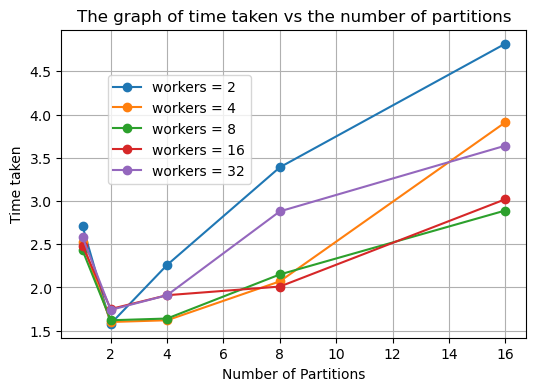

In [13]:
# Plot each column as a separate line
plt.figure(figsize=(6, 4))

for column in df_bm_t3.columns:
    plt.plot(df_bm_t3.index, df_bm_t3[column], marker='o', label=f'workers = {column}')

plt.xlabel('Number of Partitions')
plt.ylabel('Time taken')
plt.title('The graph of time taken vs the number of partitions')
plt.legend(loc=(0.1, 0.5))
plt.grid(True)
plt.show()

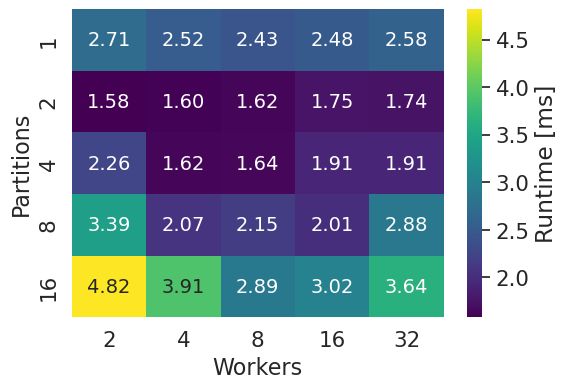

In [14]:
# Plot the heatmap
plt.figure(figsize=(6,4))
sn.set(font_scale=1.4)  # for label size

# Define the color map
cmap = 'viridis'
sn.heatmap(df_bm_t3, annot=True, annot_kws={"size": 14}, fmt=".2f",
            cbar_kws={'label': 'Runtime [ms]'}, cmap=cmap)

            
plt.xlabel('Workers', fontsize=16)
plt.ylabel('Partitions', fontsize=16)
plt.show()
plt.style.use('seaborn-darkgrid')

In [12]:
opt_nps_t3, opt_nws_t3 = df_bm_t3.min(axis=1).idxmin(), df_bm_t3.min().idxmin()

print("Optimal number of partitions for task 3 is :" ,opt_nps_t3)
print("Optimal number of workers for task 3 is :" ,opt_nws_t3)

Optimal number of partitions for task 3 is : 2
Optimal number of workers for task 3 is : 2


### Results for Task 3 with Best Performance Parameters

In [15]:
# start the cluster for optimal number of workers
cluster = SSHCluster([scheduler, worker1, worker2],
                     scheduler_options={"port": 0, "dashboard_address": ":8888"},
                     connect_options={"known_hosts": None}, 
                     worker_options={"n_workers": opt_nws_t3})
                     

client = Client(cluster)
client

2024-01-28 22:07:35,171 - distributed.deploy.ssh - INFO - 2024-01-28 22:07:35,170 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-01-28 22:07:35,172 - distributed.deploy.ssh - INFO - /home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8888 is already in use.
2024-01-28 22:07:35,173 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2024-01-28 22:07:35,173 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 32961 instead
2024-01-28 22:07:35,173 - distributed.deploy.ssh - INFO - warnings.warn(
2024-01-28 22:07:35,197 - distributed.deploy.ssh - INFO - 2024-01-28 22:07:35,196 - distributed.scheduler - INFO - State start
2024-01-28 22:07:35,199 - distributed.deploy.ssh - INFO - 2024-01-28 22:07:35,199 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22

2024-01-28 22:07:36,403 - distributed.deploy.ssh - INFO - 2024-01-28 22:07:36,403 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-hn9tze9t', purging
2024-01-28 22:07:36,403 - distributed.deploy.ssh - INFO - 2024-01-28 22:07:36,404 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ys51jh4t', purging
2024-01-28 22:07:36,403 - distributed.deploy.ssh - INFO - 2024-01-28 22:07:36,404 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-hdjramvk', purging
2024-01-28 22:07:36,404 - distributed.deploy.ssh - INFO - 2024-01-28 22:07:36,404 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-30x4082n', purging
2024-01-28 22:07:36,404 - distributed.deploy.ssh - INFO - 2024-01-28 22:07:36,404 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-de1bzq0e'

<Client: 'tcp://10.67.22.110:36513' processes=0 threads=0, memory=0 B>

In [16]:
# Load the papers and read it as bag type with best npartition value
opt_bag_t3 = db.from_sequence(json_list, npartitions = opt_nps_t3).map(load_data_files)

# Return the final computed bag with 'paper-id' and 'title-embedding'
opt_titles_t3 = opt_bag_t3.map(titles_result).compute(npartitions = opt_nps_t3)

/home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 25.94 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [17]:
# print first term in result
print('The first term:\n')
print(opt_titles_t3[0])

The first term:

{'paper-id': 'e142106dccc14c30910e705e1159d340c6a97832', 'title': 'Development of a Broadly Accessible Venezuelan Equine Encephalitis Virus Replicon Particle Vaccine Platform', 'title-embedding': [[-0.021397, -0.32793, -0.11575, 0.33918, -0.26804, 0.20629, -0.094684, -0.20468, 0.13601, 0.1971, 0.14063, 0.24682, 0.034117, -0.014365, -0.15843, -0.21497, -0.38758, -0.32978, 0.25689, 0.24237, 0.068928, -0.076904, 0.1682, -0.49266, -0.36861, -0.13722, -0.11721, 0.14748, -0.10809, 0.23416, -0.042182, 0.50656, -0.34911, 0.14945, -0.037651, 0.05063, 0.13608, 0.084523, -0.033799, -0.17386, -0.23081, -0.15391, 0.2295, 0.040268, 0.17354, -0.010978, -0.17091, -0.2466, -0.05406, 0.2729, 0.062688, -0.091113, -0.36745, 0.23183, 0.1215, -0.044421, 0.12309, 0.15553, -0.063756, 0.033778, -0.067161, -0.12405, 0.42981, -0.34691, -0.035686, -0.25121, -0.10351, -0.33918, -0.28393, 0.043214, 0.10544, 0.20633, 0.33153, 0.16134, 0.20768, -0.045038, 0.36168, -0.034047, 0.0029517, -0.046323, 0.0

In [22]:
# Convert the result to a pandas DataFrame
df_opt_titles_t3 = pd.DataFrame(opt_titles_t3)

# show dataframe of first 10 term
df_opt_titles_t3.head(10)

,paper-id,title,title-embedding
0,e142106dccc14c30910e705e1159d340c6a97832,Development of a Broadly Accessible Venezuelan...,"[[-0.021397, -0.32793, -0.11575, 0.33918, -0.2..."
1,cafa25b00fd0b65e7d337fd03a204be2acb3243f,Pre-Clinical and Clinical Efficiency of Comple...,"[[0.36475, -0.060926, -0.21272, 0.35682, -0.34..."
2,ab8da309a4060c4f4a3774c3ec9e7ebdc5a3a74e,α4-integrins control viral meningoencephalitis...,"[[-0.22723, -0.39422, -0.11448, 0.23466, -0.05..."
3,83b302c75378ce58e35ef93b6214a6ec330998c1,Modeling pathogenesis of emergent and pre-emer...,"[[0.13783, 0.059, -0.38337, 0.49877, -0.15925,..."
4,a735cd10efb7df82d87da350bc33e3ca3acab6ed,The risk of transmission of a viral haemorrhag...,"[[-0.22041, 0.043005, -0.16092, 0.42121, -0.31..."
5,266e97136335f2ef19dd7d372fe0472afa2af17c,Antibody-Mediated Internalization of Infectiou...,"[[0.12874, 0.059538, -0.30024, 0.10514, 0.0795..."
6,7f9e15b30bfa7b75a43c5d9febf1b6f71240f80b,,[]
7,630a94063d188ceeb2302472ac2e1a0da2e31216,Consecutive Inhibition of ISG15 Expression and...,"[[-0.14864, -0.22202, 0.067023, -0.011645, 0.0..."
8,3330a6e81c27b196cb5171baf11239a9560ff6e7,and clinical characteristics,"[[0.36475, -0.060926, -0.21272, 0.35682, -0.34..."
9,59cdfbf3b9e99d780b3ad6cf2985e34ec61e8f5a,A speed-fidelity trade-off determines the muta...,"[[-0.093558, 0.23423, 0.092511, 0.22334, 0.068..."


In [24]:
# Remove rows where the value in the second column is equal to NaN
df_opt_titles_t3_filtered = df_opt_titles_t3[df_opt_titles_t3.iloc[:, 2].apply(lambda x: np.array(x).ndim == 2)]

df_opt_titles_t3_filtered.head(10)

,paper-id,title,title-embedding
0,e142106dccc14c30910e705e1159d340c6a97832,Development of a Broadly Accessible Venezuelan...,"[[-0.021397, -0.32793, -0.11575, 0.33918, -0.2..."
1,cafa25b00fd0b65e7d337fd03a204be2acb3243f,Pre-Clinical and Clinical Efficiency of Comple...,"[[0.36475, -0.060926, -0.21272, 0.35682, -0.34..."
2,ab8da309a4060c4f4a3774c3ec9e7ebdc5a3a74e,α4-integrins control viral meningoencephalitis...,"[[-0.22723, -0.39422, -0.11448, 0.23466, -0.05..."
3,83b302c75378ce58e35ef93b6214a6ec330998c1,Modeling pathogenesis of emergent and pre-emer...,"[[0.13783, 0.059, -0.38337, 0.49877, -0.15925,..."
4,a735cd10efb7df82d87da350bc33e3ca3acab6ed,The risk of transmission of a viral haemorrhag...,"[[-0.22041, 0.043005, -0.16092, 0.42121, -0.31..."
5,266e97136335f2ef19dd7d372fe0472afa2af17c,Antibody-Mediated Internalization of Infectiou...,"[[0.12874, 0.059538, -0.30024, 0.10514, 0.0795..."
7,630a94063d188ceeb2302472ac2e1a0da2e31216,Consecutive Inhibition of ISG15 Expression and...,"[[-0.14864, -0.22202, 0.067023, -0.011645, 0.0..."
8,3330a6e81c27b196cb5171baf11239a9560ff6e7,and clinical characteristics,"[[0.36475, -0.060926, -0.21272, 0.35682, -0.34..."
9,59cdfbf3b9e99d780b3ad6cf2985e34ec61e8f5a,A speed-fidelity trade-off determines the muta...,"[[-0.093558, 0.23423, 0.092511, 0.22334, 0.068..."
10,44c4f131824378c773a3b2e006bed411214feec7,A Long-Term Study of a Lipid-Buprenorphine Imp...,"[[0.1519, -0.00010733, -0.062792, 0.31729, -0...."


In [25]:
Num_of_papers_run = len(df_opt_titles_t3_filtered)

print('The number of papers after title embedding:\n', Num_of_papers_run)

The number of papers after title embedding:
 946


In [28]:
client.close()

## Task 4: Cosine Similarity for the Title

### Performance Benchmarking 

In [29]:
# We adopt the following method to calculate the cosine similarity:
# to take the column wise mean value of all the vectors in the embedding matrix for each title

df_opt_titles_t3_filtered['mean-embedding-matrix'] = df_opt_titles_t3_filtered['title-embedding'].apply(lambda emm_vector:[np.mean(emm_vector, axis=0)]) 
df_opt_titles_t3_filtered.head(3)

/tmp/ipykernel_377833/222738864.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_opt_titles_t3_filtered['mean-embedding-matrix'] = df_opt_titles_t3_filtered['title-embedding'].apply(lambda emm_vector:[np.mean(emm_vector, axis=0)])


,paper-id,title,title-embedding,mean-embedding-matrix
0,e142106dccc14c30910e705e1159d340c6a97832,Development of a Broadly Accessible Venezuelan...,"[[-0.021397, -0.32793, -0.11575, 0.33918, -0.2...","[[-0.07084985714285714, 0.004054585714285709, ..."
1,cafa25b00fd0b65e7d337fd03a204be2acb3243f,Pre-Clinical and Clinical Efficiency of Comple...,"[[0.36475, -0.060926, -0.21272, 0.35682, -0.34...","[[0.11194000000000001, 0.085907, -0.189625, 0...."
2,ab8da309a4060c4f4a3774c3ec9e7ebdc5a3a74e,α4-integrins control viral meningoencephalitis...,"[[-0.22723, -0.39422, -0.11448, 0.23466, -0.05...","[[0.11679500000000001, -0.1331555, -0.27578075..."


In [30]:
# put the vector to a list
matrices = df_opt_titles_t3_filtered['mean-embedding-matrix'].tolist()

# print the length of 
print(len(matrices[1][0]))

300


In [31]:
# function to calculate the cosine similarity for every couple of the mean embedded titles

def calculate_sim_max(vector):
    #claim the variable
    sim_max = 0
    index_max = 0
    
    for i in range(len(matrices)):
        sim = cosine_similarity(vector, matrices[i])[0][0]
        
        if sim > sim_max and sim < 0.99:
            
            sim_max = sim
            index_max = i
            
    return (sim_max ,index_max)

In [32]:
# number of partitions 
# npartitions = [1, 2, 4, 8, 16, 32, 64, 128]
npartitions = [1, 2, 4, 8, 16]

# number of workers
# nworkers = [1, 2, 4, 8, 16, 32, 64, 128]
nworkers = [1, 2, 4, 8, 16]

# claim 3 vms name
scheduler = '10.67.22.110'
worker1 = '10.67.22.156'
worker2 = '10.67.22.62'

In [33]:
def calculate_time_t4(npartitions):
    
    start_time =  time.perf_counter()
    # change pandas dataframe to dask dataframe with parameter npartitions
    dask_df = dd.from_pandas(df_opt_titles_t3_filtered, npartitions=npartitions)
    cos_sim = dask_df['mean-embedding-matrix'].apply(calculate_sim_max,meta=('x', 'object')).compute()   
    
    end_time =  time.perf_counter()
    time_taken = end_time - start_time
    
    return time_taken

In [34]:
# run the loop for benchmarking
bm_result_t4 = np.full((len(npartitions) , len(nworkers)) , np.nan)  

for i , nws in enumerate(nworkers):

    cluster = SSHCluster([scheduler, worker1, worker2],
                    scheduler_options={"port": 0, "dashboard_address": ":8888"},
                    connect_options={"known_hosts": None}, 
                    worker_options={"n_workers": nws})


    client = Client(cluster)

    for j , nps in enumerate(npartitions):
        bm_result = calculate_time_t4(nps)
        bm_result_t4[j][i] = bm_result 
        print('For number of partitions is:', nps, 'and number of workers is:', nws * 2 , 'the running time is:', bm_result, 'seconds')

    client.close()
    cluster.close()

2024-01-28 22:10:51,191 - distributed.deploy.ssh - INFO - 2024-01-28 22:10:51,190 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-01-28 22:10:51,193 - distributed.deploy.ssh - INFO - /home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8888 is already in use.
2024-01-28 22:10:51,193 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2024-01-28 22:10:51,193 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 33235 instead
2024-01-28 22:10:51,195 - distributed.deploy.ssh - INFO - warnings.warn(
2024-01-28 22:10:51,217 - distributed.deploy.ssh - INFO - 2024-01-28 22:10:51,216 - distributed.scheduler - INFO - State start
2024-01-28 22:10:51,219 - distributed.deploy.ssh - INFO - 2024-01-28 22:10:51,219 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22

For number of partitions is: 1 and number of workers is: 2 the running time is: 252.62237193249166 seconds
For number of partitions is: 2 and number of workers is: 2 the running time is: 127.41641855426133 seconds


/home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 15.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


For number of partitions is: 4 and number of workers is: 2 the running time is: 153.05746268015355 seconds


/home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 15.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


For number of partitions is: 8 and number of workers is: 2 the running time is: 169.56645685154945 seconds


/home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 15.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


For number of partitions is: 16 and number of workers is: 2 the running time is: 170.26287454273552 seconds


2024-01-28 22:25:26,670 - distributed.deploy.ssh - INFO - 2024-01-28 22:25:26,669 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-01-28 22:25:26,672 - distributed.deploy.ssh - INFO - /home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8888 is already in use.
2024-01-28 22:25:26,673 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2024-01-28 22:25:26,673 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 42351 instead
2024-01-28 22:25:26,673 - distributed.deploy.ssh - INFO - warnings.warn(
2024-01-28 22:25:26,698 - distributed.deploy.ssh - INFO - 2024-01-28 22:25:26,698 - distributed.scheduler - INFO - State start
2024-01-28 22:25:26,701 - distributed.deploy.ssh - INFO - 2024-01-28 22:25:26,700 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22

For number of partitions is: 1 and number of workers is: 4 the running time is: 256.1063310857862 seconds
For number of partitions is: 2 and number of workers is: 4 the running time is: 129.57437327038497 seconds


/home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 15.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


For number of partitions is: 4 and number of workers is: 4 the running time is: 66.19380321726203 seconds


/home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 15.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


For number of partitions is: 8 and number of workers is: 4 the running time is: 79.95831235963851 seconds


/home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 15.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


For number of partitions is: 16 and number of workers is: 4 the running time is: 110.92089440394193 seconds


2024-01-28 22:36:12,042 - distributed.deploy.ssh - INFO - 2024-01-28 22:36:12,041 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-01-28 22:36:12,044 - distributed.deploy.ssh - INFO - /home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8888 is already in use.
2024-01-28 22:36:12,045 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2024-01-28 22:36:12,046 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 33575 instead
2024-01-28 22:36:12,047 - distributed.deploy.ssh - INFO - warnings.warn(
2024-01-28 22:36:12,068 - distributed.deploy.ssh - INFO - 2024-01-28 22:36:12,067 - distributed.scheduler - INFO - State start
2024-01-28 22:36:12,070 - distributed.deploy.ssh - INFO - 2024-01-28 22:36:12,070 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22

2024-01-28 22:36:13,359 - distributed.deploy.ssh - INFO - 2024-01-28 22:36:13,357 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:36:13,360 - distributed.deploy.ssh - INFO - 2024-01-28 22:36:13,357 - distributed.worker - INFO -               Threads:                          4
2024-01-28 22:36:13,361 - distributed.deploy.ssh - INFO - 2024-01-28 22:36:13,357 - distributed.worker - INFO -                Memory:                   7.75 GiB
2024-01-28 22:36:13,362 - distributed.deploy.ssh - INFO - 2024-01-28 22:36:13,358 - distributed.worker - INFO -       Local Directory: /tmp/dask-scratch-space/worker-9vthpo2l
2024-01-28 22:36:13,363 - distributed.deploy.ssh - INFO - 2024-01-28 22:36:13,358 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:36:13,375 - distributed.deploy.ssh - INFO - 2024-01-28 22:36:13,377 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.156:37743
2024-01-28 22:3

For number of partitions is: 1 and number of workers is: 8 the running time is: 267.3323943661526 seconds
For number of partitions is: 2 and number of workers is: 8 the running time is: 130.00218302104622 seconds


/home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 15.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


For number of partitions is: 4 and number of workers is: 8 the running time is: 70.35290974099189 seconds


/home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 15.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


For number of partitions is: 8 and number of workers is: 8 the running time is: 39.637918901629746 seconds


/home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 15.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


For number of partitions is: 16 and number of workers is: 8 the running time is: 54.90791928116232 seconds


2024-01-28 22:45:36,932 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:36,932 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-01-28 22:45:36,934 - distributed.deploy.ssh - INFO - /home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8888 is already in use.
2024-01-28 22:45:36,935 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2024-01-28 22:45:36,935 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 42961 instead
2024-01-28 22:45:36,936 - distributed.deploy.ssh - INFO - warnings.warn(
2024-01-28 22:45:36,958 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:36,957 - distributed.scheduler - INFO - State start
2024-01-28 22:45:36,960 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:36,960 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22

2024-01-28 22:45:38,397 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:38,398 - distributed.worker - INFO -          Listening to:    tcp://10.67.22.62:37175
2024-01-28 22:45:38,398 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:38,398 - distributed.worker - INFO -          dashboard at:          10.67.22.62:34427
2024-01-28 22:45:38,400 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:38,398 - distributed.worker - INFO - Waiting to connect to:   tcp://10.67.22.110:34065
2024-01-28 22:45:38,400 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:38,398 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:45:38,401 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:38,398 - distributed.worker - INFO -               Threads:                          4
2024-01-28 22:45:38,402 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:38,400 - distributed.worker - INFO -                Memory:                   7.75 GiB
2024-01-28 22:45:38,403 - di

2024-01-28 22:45:38,427 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:38,417 - distributed.worker - INFO -       Local Directory: /tmp/dask-scratch-space/worker-af03fxqe
2024-01-28 22:45:38,428 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:38,417 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:45:38,431 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:38,431 - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.62:44895
2024-01-28 22:45:38,431 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:38,432 - distributed.worker - INFO -          Listening to:    tcp://10.67.22.62:44895
2024-01-28 22:45:38,431 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:38,432 - distributed.worker - INFO -          dashboard at:          10.67.22.62:34935
2024-01-28 22:45:38,432 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:38,432 - distributed.worker - INFO - Waiting to connect to:   tcp://10.67.22.110:34065
2024-01-28 22:4

2024-01-28 22:45:38,555 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:38,554 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:45:38,555 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:38,554 - distributed.worker - INFO -               Threads:                          4
2024-01-28 22:45:38,555 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:38,554 - distributed.worker - INFO -                Memory:                   7.75 GiB
2024-01-28 22:45:38,556 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:38,554 - distributed.worker - INFO -       Local Directory: /tmp/dask-scratch-space/worker-9cpsnebo
2024-01-28 22:45:38,556 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:38,554 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:45:38,559 - distributed.deploy.ssh - INFO - 2024-01-28 22:45:38,561 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.156:38067
2024-01-28 22:4

For number of partitions is: 1 and number of workers is: 16 the running time is: 265.9112542150542 seconds
For number of partitions is: 2 and number of workers is: 16 the running time is: 134.04939074255526 seconds


/home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 15.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


For number of partitions is: 4 and number of workers is: 16 the running time is: 72.27761540841311 seconds


/home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 15.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


For number of partitions is: 8 and number of workers is: 16 the running time is: 64.17372894566506 seconds


/home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 15.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


For number of partitions is: 16 and number of workers is: 16 the running time is: 45.64955642912537 seconds


2024-01-28 22:55:21,953 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:21,952 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-01-28 22:55:21,955 - distributed.deploy.ssh - INFO - /home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8888 is already in use.
2024-01-28 22:55:21,956 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2024-01-28 22:55:21,956 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 40529 instead
2024-01-28 22:55:21,956 - distributed.deploy.ssh - INFO - warnings.warn(
2024-01-28 22:55:21,979 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:21,978 - distributed.scheduler - INFO - State start
2024-01-28 22:55:21,981 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:21,981 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22

2024-01-28 22:55:23,667 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:23,667 - distributed.worker - INFO - Waiting to connect to:   tcp://10.67.22.110:35895
2024-01-28 22:55:23,668 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:23,667 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:55:23,668 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:23,667 - distributed.worker - INFO -               Threads:                          4
2024-01-28 22:55:23,668 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:23,667 - distributed.worker - INFO -                Memory:                   7.75 GiB
2024-01-28 22:55:23,669 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:23,667 - distributed.worker - INFO -       Local Directory: /tmp/dask-scratch-space/worker-hof12uwb
2024-01-28 22:55:23,669 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:23,667 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:5

2024-01-28 22:55:23,874 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:23,873 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:55:23,875 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:23,876 - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.62:38967
2024-01-28 22:55:23,877 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:23,880 - distributed.worker - INFO -          Listening to:    tcp://10.67.22.62:38967
2024-01-28 22:55:23,878 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:23,880 - distributed.worker - INFO -          dashboard at:          10.67.22.62:41683
2024-01-28 22:55:23,878 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:23,880 - distributed.worker - INFO - Waiting to connect to:   tcp://10.67.22.110:35895
2024-01-28 22:55:23,878 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:23,880 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:55:23,879 - di

2024-01-28 22:55:24,138 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,139 - distributed.worker - INFO -               Threads:                          4
2024-01-28 22:55:24,139 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,139 - distributed.worker - INFO -                Memory:                   7.75 GiB
2024-01-28 22:55:24,139 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,139 - distributed.worker - INFO -       Local Directory: /tmp/dask-scratch-space/worker-e5rjzicz
2024-01-28 22:55:24,139 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,139 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:55:24,142 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,142 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.156:36871
2024-01-28 22:55:24,143 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,142 - distributed.worker - INFO -          Listening to:   tcp://10.67.22.156:36871
2024-01-28 22:5

2024-01-28 22:55:24,237 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,239 - distributed.worker - INFO -          dashboard at:          10.67.22.62:37469
2024-01-28 22:55:24,238 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,239 - distributed.worker - INFO - Waiting to connect to:   tcp://10.67.22.110:35895
2024-01-28 22:55:24,238 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,239 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:55:24,239 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,239 - distributed.worker - INFO -               Threads:                          4
2024-01-28 22:55:24,239 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,239 - distributed.worker - INFO -                Memory:                   7.75 GiB
2024-01-28 22:55:24,239 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,239 - distributed.worker - INFO -       Local Directory: /tmp/dask-scratch-space/worker-3xz391uy
2024-01-28 22:5

2024-01-28 22:55:24,340 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,340 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:55:24,464 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,466 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.156:34605
2024-01-28 22:55:24,465 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,468 - distributed.worker - INFO -          Listening to:   tcp://10.67.22.156:34605
2024-01-28 22:55:24,466 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,468 - distributed.worker - INFO -          dashboard at:         10.67.22.156:34431
2024-01-28 22:55:24,467 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,468 - distributed.worker - INFO - Waiting to connect to:   tcp://10.67.22.110:35895
2024-01-28 22:55:24,467 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,468 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:55:24,467 - di

2024-01-28 22:55:24,589 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,590 - distributed.worker - INFO -               Threads:                          4
2024-01-28 22:55:24,589 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,590 - distributed.worker - INFO -                Memory:                   7.75 GiB
2024-01-28 22:55:24,590 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,591 - distributed.worker - INFO -       Local Directory: /tmp/dask-scratch-space/worker-08h175ga
2024-01-28 22:55:24,590 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,591 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 22:55:24,593 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,596 - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.62:38743
2024-01-28 22:55:24,596 - distributed.deploy.ssh - INFO - 2024-01-28 22:55:24,599 - distributed.worker - INFO -          Listening to:    tcp://10.67.22.62:38743
2024-01-28 22:5

For number of partitions is: 1 and number of workers is: 32 the running time is: 247.18013165798038 seconds
For number of partitions is: 2 and number of workers is: 32 the running time is: 136.57053760066628 seconds


/home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 15.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


For number of partitions is: 4 and number of workers is: 32 the running time is: 85.86094823665917 seconds


/home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 15.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


For number of partitions is: 8 and number of workers is: 32 the running time is: 62.02193220704794 seconds


/home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 15.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


For number of partitions is: 16 and number of workers is: 32 the running time is: 87.8079432239756 seconds


In [35]:
# reshaped the result array to a dataframe
re_bm_result_t4 = np.array(bm_result_t4).reshape(len(npartitions), len(nworkers))
df_bm_t4 = pd.DataFrame((re_bm_result_t4).round(2), index = npartitions, columns = np.array(nworkers)*2)

df_bm_t4

,2,4,8,16,32
1,252.62,256.11,267.33,265.91,247.18
2,127.42,129.57,130.00,134.05,136.57
4,153.06,66.19,70.35,72.28,85.86
8,169.57,79.96,39.64,64.17,62.02
16,170.26,110.92,54.91,45.65,87.81


In [36]:
# optimal parameters
opt_nps_t4, opt_nws_t4 = df_bm_t4.min(axis=1).idxmin(), df_bm_t4.min().idxmin()

print("Optimal number of partitions for task 3 is :" ,opt_nps_t4)
print("Optimal number of workers for task 3 is :" ,opt_nws_t4)

Optimal number of partitions for task 3 is : 8
Optimal number of workers for task 3 is : 8


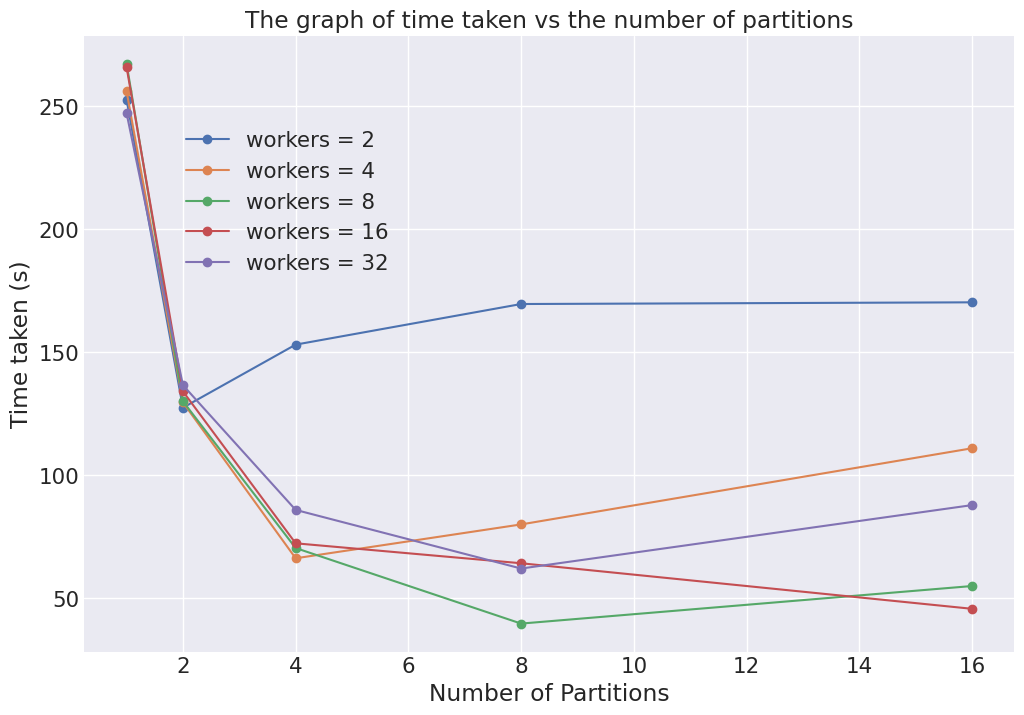

In [37]:
# Plot each column as a separate line
plt.figure(figsize=(12, 8))

for column in df_bm_t4.columns:
    plt.plot(df_bm_t4.index, df_bm_t4[column], marker='o', label=f'workers = {column}')

plt.xlabel('Number of Partitions')
plt.ylabel('Time taken (s)')
plt.title('The graph of time taken vs the number of partitions')
plt.legend(loc=(0.1, 0.6))
plt.grid(True)
plt.show()

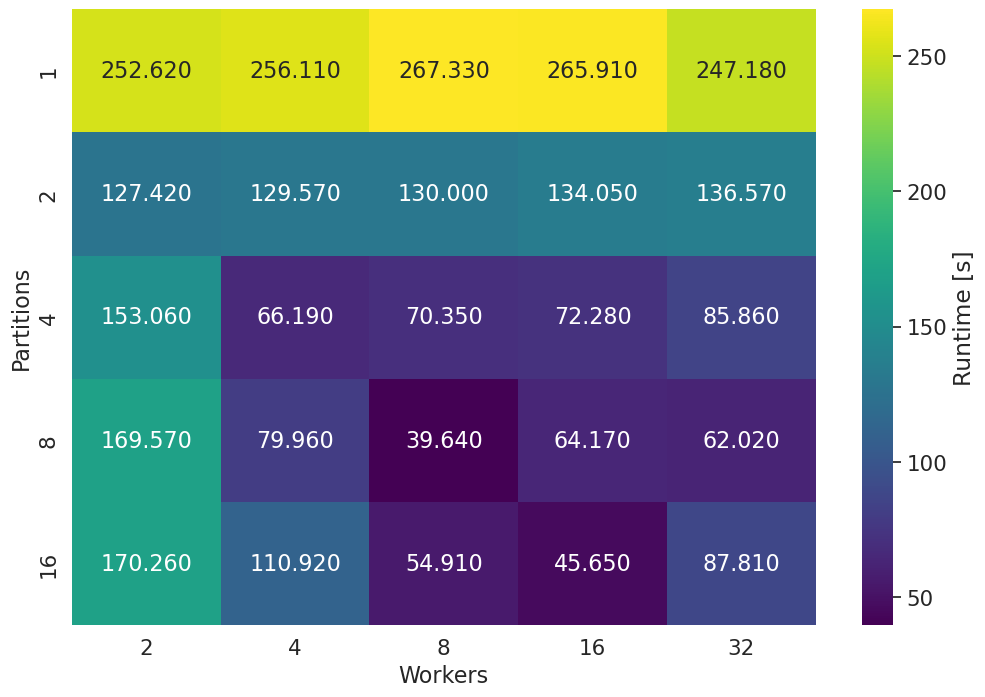

In [38]:
# Plot the heatmap
plt.figure(figsize=(12, 8))
sn.set(font_scale=1.4)  # for label size

# Define the custom color map from white to blue and then red
cmap = 'viridis'

sn.heatmap(df_bm_t4, annot=True, annot_kws={"size": 16}, fmt=".3f",
            cbar_kws={'label': 'Runtime [s]'}, cmap=cmap)
plt.xlabel('Workers', fontsize=16)
plt.ylabel('Partitions', fontsize=16)
plt.show()
plt.style.use('default')

### Results for Task 4 with Best Performance Parameters

In [39]:
# start the cluster for optimal number of workers
cluster = SSHCluster([scheduler, worker1, worker2],
                     scheduler_options={"port": 0, "dashboard_address": ":8888"},
                     connect_options={"known_hosts": None}, 
                     worker_options={"n_workers": 4})
                     
client = Client(cluster)
client

2024-01-28 23:06:12,925 - distributed.deploy.ssh - INFO - 2024-01-28 23:06:12,924 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-01-28 23:06:12,926 - distributed.deploy.ssh - INFO - /home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8888 is already in use.
2024-01-28 23:06:12,927 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2024-01-28 23:06:12,927 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 40681 instead
2024-01-28 23:06:12,928 - distributed.deploy.ssh - INFO - warnings.warn(
2024-01-28 23:06:12,950 - distributed.deploy.ssh - INFO - 2024-01-28 23:06:12,950 - distributed.scheduler - INFO - State start
2024-01-28 23:06:12,953 - distributed.deploy.ssh - INFO - 2024-01-28 23:06:12,953 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22

2024-01-28 23:06:14,009 - distributed.deploy.ssh - INFO - 2024-01-28 23:06:14,007 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 23:06:14,010 - distributed.deploy.ssh - INFO - 2024-01-28 23:06:14,011 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.156:45507
2024-01-28 23:06:14,011 - distributed.deploy.ssh - INFO - 2024-01-28 23:06:14,011 - distributed.worker - INFO -          Listening to:   tcp://10.67.22.156:45507
2024-01-28 23:06:14,011 - distributed.deploy.ssh - INFO - 2024-01-28 23:06:14,011 - distributed.worker - INFO -          dashboard at:         10.67.22.156:44683
2024-01-28 23:06:14,012 - distributed.deploy.ssh - INFO - 2024-01-28 23:06:14,011 - distributed.worker - INFO - Waiting to connect to:   tcp://10.67.22.110:34207
2024-01-28 23:06:14,012 - distributed.deploy.ssh - INFO - 2024-01-28 23:06:14,011 - distributed.worker - INFO - -------------------------------------------------
2024-01-28 23:06:14,012 - di

<Client: 'tcp://10.67.22.110:34207' processes=0 threads=0, memory=0 B>

In [40]:
# run the task4 with best npartitions number
opt_dask_df = dd.from_pandas(df_opt_titles_t3_filtered, npartitions = 8)
opt_cos_sim = opt_dask_df['mean-embedding-matrix'].apply(calculate_sim_max,meta=('x', 'object')).compute()       

/home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 15.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [42]:
# to construct a new dataframe to store the result: 'cs' and 'index'
df_cosine_sim = pd.Series(opt_cos_sim, name='cosine similarity').apply(lambda paper: pd.Series({'cosine_similarity_max': paper[0], 'paper_index': paper[1]}))
df_cosine_sim['paper_index'] = df_cosine_sim['paper_index'].astype(int)

# Concatenate the dataframes and drop the index
df_result = pd.concat([df_opt_titles_t3_filtered, df_cosine_sim], axis=1)
df_result = df_result.reset_index(drop=True)

df_result.head(5)

,paper-id,title,title-embedding,mean-embedding-matrix,cosine_similarity_max,paper_index
0,e142106dccc14c30910e705e1159d340c6a97832,Development of a Broadly Accessible Venezuelan...,"[[-0.021397, -0.32793, -0.11575, 0.33918, -0.2...","[[-0.07084985714285714, 0.004054585714285709, ...",0.808007,634
1,cafa25b00fd0b65e7d337fd03a204be2acb3243f,Pre-Clinical and Clinical Efficiency of Comple...,"[[0.36475, -0.060926, -0.21272, 0.35682, -0.34...","[[0.11194000000000001, 0.085907, -0.189625, 0....",0.805909,7
2,ab8da309a4060c4f4a3774c3ec9e7ebdc5a3a74e,α4-integrins control viral meningoencephalitis...,"[[-0.22723, -0.39422, -0.11448, 0.23466, -0.05...","[[0.11679500000000001, -0.1331555, -0.27578075...",0.860329,177
3,83b302c75378ce58e35ef93b6214a6ec330998c1,Modeling pathogenesis of emergent and pre-emer...,"[[0.13783, 0.059, -0.38337, 0.49877, -0.15925,...","[[0.23237333333333332, 0.0056539999999999984, ...",0.803809,943
4,a735cd10efb7df82d87da350bc33e3ca3acab6ed,The risk of transmission of a viral haemorrhag...,"[[-0.22041, 0.043005, -0.16092, 0.42121, -0.31...","[[0.048884550000000006, -0.13997374999999998, ...",0.835668,648


In [53]:
# print the most relavant two papers
# extract the index 
index = df_result['cosine_similarity_max'].idxmax()

# Get the value of the record
max_index = df_result.loc[index, 'paper_index']

# Get the titles for both records
max_sim = df_result.loc[index, 'cosine_similarity_max']

title1 = df_result.loc[index, 'title']
title2 = df_result.loc[max_index, 'title']

# Print the titles and similarities
print('maximum similarity:')
print("Similarity:", max_sim)
print("Paper 1:", title1)
print("Paper 2:", title2)

maximum similarity:
Similarity: 0.9686094568996692
Paper 1: Integration of shared-pathogen networks and machine learning reveals the key aspects of zoonoses and predicts mammalian reservoirs
Paper 2: Integration of shared-pathogen networks and machine learning reveal key aspects of zoonoses and predict mammalian reservoirs -Electronic Supplementary Materials


In [59]:
# Drop the row with the maximum value to find the second maximum
df_second_max = df_result.drop(index=[index,max_index])

# Locate the index of the record with the second maximum value in 'cosine_similarity_max'
second_max_similarity_index = df_second_max['cosine_similarity_max'].idxmax()

# Get the value of 'paper_index' for the second maximum record
second_max_index = df_second_max.loc[second_max_similarity_index, 'paper_index']

# Get the titles and similarities for the second maximum value
second_max_similarity = df_second_max.loc[second_max_similarity_index, 'cosine_similarity_max']
title3 = df_second_max.loc[second_max_similarity_index, 'title']
title4 = df_second_max.loc[second_max_index, 'title']

# Print the titles and similarities for the second maximum value
print('\nSecond Maximum Similarity:')
print("Similarity:", second_max_similarity)
print("Paper 3:", title3)
print("Paper 4:", title4)


Second Maximum Similarity:
Similarity: 0.9677541836127681
Paper 3: Antiviral activity of interleukin-11 as a response to porcine epidemic diarrhea virus infection
Paper 4: In Vivo Activity of Amodiaquine against ebola Virus infection


In [60]:
# Drop the row with the second maximum value to find the third maximum
df_third_max = df_second_max.drop(index=[second_max_similarity_index,second_max_index])

# Locate the index of the record with the third maximum value in 'cosine_similarity_max'
third_max_similarity_index = df_third_max['cosine_similarity_max'].idxmax()

# Get the value of 'paper_index' for the third maximum record
third_max_index = df_third_max.loc[third_max_similarity_index, 'paper_index']

# Get the titles and similarities for the third maximum value
third_max_similarity = df_third_max.loc[third_max_similarity_index, 'cosine_similarity_max']
title5 = df_third_max.loc[third_max_similarity_index, 'title']
title6 = df_third_max.loc[third_max_index, 'title']

# Print the titles and similarities for the third maximum value
print('\nThird Maximum Similarity:')
print("Similarity:", third_max_similarity)
print("Paper 5:", title5)
print("Paper 6:", title6)


Third Maximum Similarity:
Similarity: 0.9621728497715767
Paper 5: Complete Genome Sequence of Human Coronavirus NL63 CN0601/14, First Isolated in South Korea
Paper 6: Complete Genome Sequences of Porcine Deltacoronavirus Strains DH1/2016 and DH2/2016 Isolated in South Korea


In [61]:
client.close()
cluster.close()